# Traitement batch et ETL

Dans un premier temps, on charge les données à partir du hdfs, puis on effectuera une exploration pour vérifier la qualité des données, ensuite on procedera à un nettoyage des données.

In [8]:
pip install matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 31.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 32.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 30.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12/12 [seaborn]1/12 [seaborn]ib]
Note: you may need to restart the kernel to use updated packages.


In [14]:
#imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, count, mean, stddev, regexp_extract
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
#initialisation de la session spark
spark = SparkSession.builder \
    .appName("BatchETLPipelineEnhanced") \
    .master("local[*]") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://namenode:9000") \
    .getOrCreate()

In [6]:
#chargement du csv movies
movies = spark.read.csv(
    "hdfs://namenode:9000/movie-lens/rawdata/movie.csv",
    header=True, inferSchema=True
)

In [13]:
# 1. Afficher le schéma du DataFrame
movies.printSchema()

# 2. Afficher les 5 premières lignes
movies.show(5, truncate=False)

# 3. Nombre de colonnes et de lignes
num_cols = len(movies.columns)
num_rows = movies.count()
print(f"Nombre de colonnes : {num_cols}")
print(f"Nombre de lignes : {num_rows}")

# 4. Résumé statistique
movies.describe().show()

# 5. Colonnes avec valeurs nulles
from pyspark.sql.functions import col, sum as _sum

null_counts = movies.select([_sum(col(c).isNull().cast("int")).alias(c) for c in movies.columns])
null_counts.show()

# 6. Distribution des films par année

movies = movies.withColumn("year", regexp_extract("title", r"\((\d{4})\)", 1).cast("int"))
movies.select("title", "year").show(5)

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows

Nombre de colonnes : 3
Nombre de lignes : 27278
+----

     year  nb_films
0    1891         1
1    1893         1
2    1894         2
3    1895         2
4    1896         2
..    ...       ...
113  2011      1016
114  2012      1022
115  2013      1011
116  2014       740
117  2015       120

[118 rows x 2 columns]


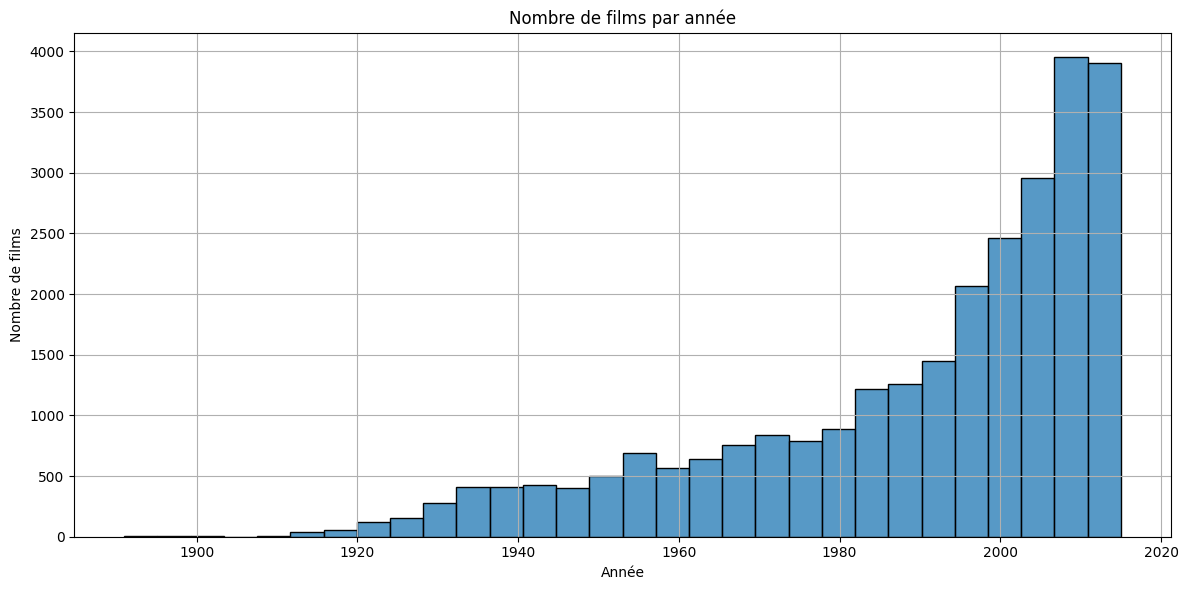

In [21]:
# Convertir en Pandas pour visualisation
movies_pd = movies.select("year").dropna().toPandas()

# Compter le nombre de films par année
films_par_annee = movies_pd.groupby("year").size().reset_index(name="nb_films")
films_par_annee = films_par_annee.sort_values("year")  # tri par année croissante

# 🧾 Afficher le tableau
print(films_par_annee)

# 7. Visualisation : nombre de films par année
plt.figure(figsize=(12, 6))
sns.histplot(data=movies_pd, x="year", bins=30, kde=False)
plt.title("Nombre de films par année")
plt.xlabel("Année")
plt.ylabel("Nombre de films")
plt.grid(True)
plt.tight_layout()
plt.show()

+------------------+-----+
|             genre|count|
+------------------+-----+
|             Drama|13344|
|            Comedy| 8374|
|          Thriller| 4178|
|           Romance| 4127|
|            Action| 3520|
|             Crime| 2939|
|            Horror| 2611|
|       Documentary| 2471|
|         Adventure| 2329|
|            Sci-Fi| 1743|
|           Mystery| 1514|
|           Fantasy| 1412|
|               War| 1194|
|          Children| 1139|
|           Musical| 1036|
|         Animation| 1027|
|           Western|  676|
|         Film-Noir|  330|
|(no genres listed)|  246|
|              IMAX|  196|
+------------------+-----+



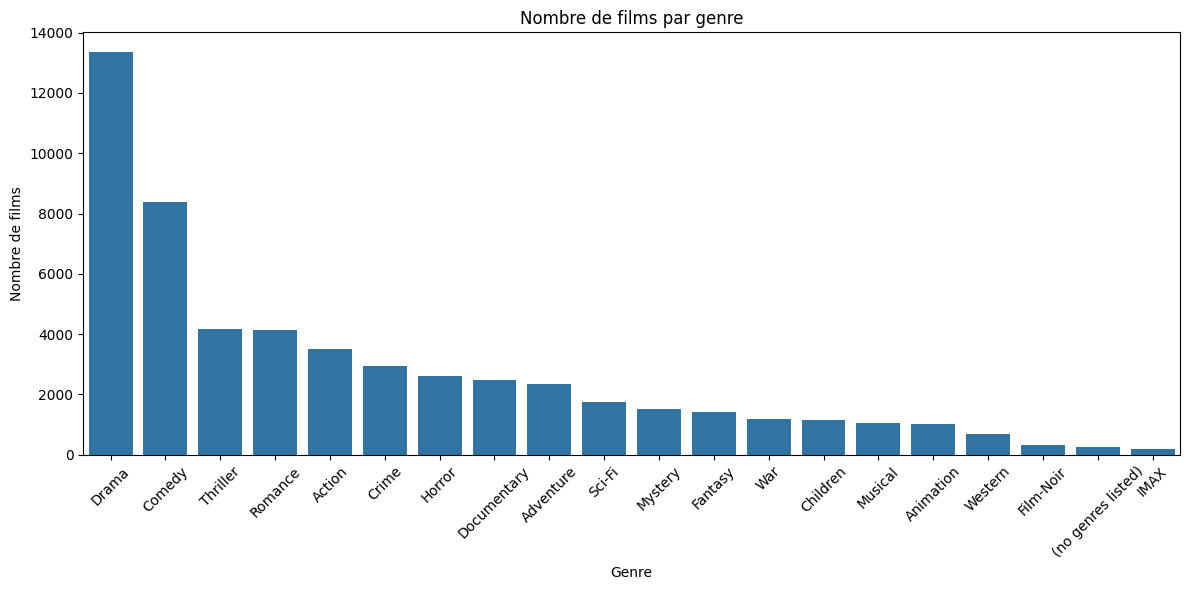

In [18]:
# 8. Genres les plus fréquents
if 'genres' in movies.columns:
    from pyspark.sql.functions import explode, split
    
    genre_counts = (
        movies
        .withColumn("genre", explode(split("genres", r"\|")))
        .groupBy("genre")
        .count()
        .orderBy("count", ascending=False)
    )
    genre_counts.show()

    # Visualisation
    genre_pd = genre_counts.toPandas()
    plt.figure(figsize=(12, 6))
    sns.barplot(x="genre", y="count", data=genre_pd)
    plt.xticks(rotation=45)
    plt.title("Nombre de films par genre")
    plt.xlabel("Genre")
    plt.ylabel("Nombre de films")
    plt.tight_layout()
    plt.show()

Pour le dataset movie, il n'y a pas de valeur manquante, il n'y a pas de nettoyage nécessaire, le genre "Drama" est le plus représenté dans le dataset et que c'est durant les deux dernières décennies que le plus de films sont sortis.